<a href="https://colab.research.google.com/github/nerobite/neural_networks/blob/main/%D0%A0%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

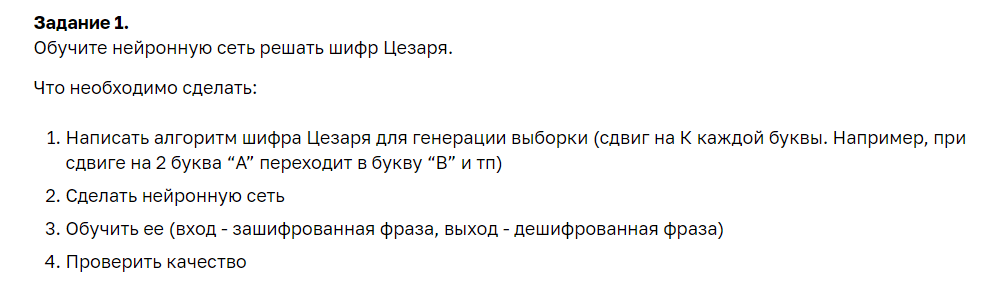

In [3]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
import pandas as pd
import time

In [1]:
# Функция шифрования данных
def caesar_cipher(text, shift, decrypt=False):
    alphabet = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
    result = ""
    shift = -shift if decrypt else shift
    for char in text.upper():
        if char in alphabet:
            idx = (alphabet.index(char) + shift) % len(alphabet)
            result += alphabet[idx]
        else:
            result += char
    return result

# Примеры использования:
encrypted = caesar_cipher("ПРИВЕТ МИР", 3)
print("Encrypted:", encrypted)

decrypted = caesar_cipher(encrypted, 3, decrypt=True)
print("Decrypted:", decrypted)


Encrypted: ТУЛЕЗХ ПЛУ
Decrypted: ПРИВЕТ МИР


In [4]:
encrypted = caesar_cipher("ПРИВЕТ МИР", 2)
print("Encrypted:", encrypted)

decrypted = caesar_cipher(encrypted, 2, decrypt=True)
print("Decrypted:", decrypted)

Encrypted: СТКДЖФ ОКТ
Decrypted: ПРИВЕТ МИР


In [18]:
#добавим генерацию данных
def generate_data(num_samples, max_length, shift):
    data = []
    alphabet = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ '
    for _ in range(num_samples):
        text = ''.join(random.choices(alphabet, k=max_length))
        encrypted_text = caesar_cipher(text, shift)
        data.append((encrypted_text, text))
    return data

In [20]:
data = generate_data(10000, 5, 3)
print(data[:5])

[('ЪЛШЕЮ', 'ЧИХВЫ'), ('ОКЛФС', 'ЛЗИСО'), ('ЁЛВД ', 'ГИЯБ '), ('ЬУШЫ ', 'ЩРХШ '), ('ИЪТЁП', 'ЁЧПГМ')]


In [12]:
class TextDataset(Dataset):
    def __init__(self, data, alphabet):
        self.data = data
        self.alphabet = alphabet
        self.char_to_idx = {char: idx for idx, char in enumerate(alphabet)}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        encrypted, decrypted = self.data[idx]
        X = [self.char_to_idx[char] for char in encrypted]
        y = [self.char_to_idx[char] for char in decrypted]
        return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

class DecoderModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(DecoderModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x


In [21]:
# Параметры
alphabet = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ '
vocab_size = len(alphabet)
embed_size = 64
hidden_size = 128
batch_size = 64
num_epochs = 10
learning_rate = 0.001

# Подготовка данных
data = generate_data(1000, 10, 3) # генерируем данные
dataset = TextDataset(data, alphabet)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [22]:

# Модель
model = DecoderModel(vocab_size, embed_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [23]:
# Обучение
for epoch in range(num_epochs):
    for X, y in dataloader:
        outputs = model(X)
        loss = criterion(outputs.view(-1, vocab_size), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")



Epoch 1/10, Loss: 3.0941781997680664
Epoch 2/10, Loss: 2.3911311626434326
Epoch 3/10, Loss: 1.2839345932006836
Epoch 4/10, Loss: 0.4979991912841797
Epoch 5/10, Loss: 0.19942441582679749
Epoch 6/10, Loss: 0.11114463955163956
Epoch 7/10, Loss: 0.07908125221729279
Epoch 8/10, Loss: 0.0590883269906044
Epoch 9/10, Loss: 0.04529499635100365
Epoch 10/10, Loss: 0.03577084466814995


In [25]:
def decode_sequence(sequence, idx_to_char):
    return ''.join([idx_to_char[idx] for idx in sequence])

# Проверка на новых данных
test_data = generate_data(10, 5, 3)
test_dataset = TextDataset(test_data, alphabet)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        outputs = model(X)
        predicted = torch.argmax(outputs, dim=2).squeeze(0)
        predicted_text = decode_sequence(predicted.tolist(), test_dataset.idx_to_char)
        actual_text = decode_sequence(y.squeeze(0).tolist(), test_dataset.idx_to_char)
        encrypted_text = decode_sequence(X.squeeze(0).tolist(), test_dataset.idx_to_char)

        print(f"Encrypted: {encrypted_text}, Predicted: {predicted_text}, Actual: {actual_text}")


Encrypted: ЯХЦФЬ, Predicted: ЬТУСЩ, Actual: ЬТУСЩ
Encrypted: ЭЬБКЕ, Predicted: ЪЩЮЗВ, Actual: ЪЩЮЗВ
Encrypted: ШСВСЫ, Predicted: ХОЯОШ, Actual: ХОЯОШ
Encrypted: С ШЫП, Predicted: О ХШМ, Actual: О ХШМ
Encrypted: ЪМ ЭЛ, Predicted: ЧЙ ЪИ, Actual: ЧЙ ЪИ
Encrypted: ГГУУД, Predicted: ААРРБ, Actual: ААРРБ
Encrypted: ТЦЧ Н, Predicted: ПУФ К, Actual: ПУФ К
Encrypted: ЭХХСЛ, Predicted: ЪТТОИ, Actual: ЪТТОИ
Encrypted: КЧ ЧУ, Predicted: ЗФ ФР, Actual: ЗФ ФР
Encrypted: ХСХПШ, Predicted: ТОТМХ, Actual: ТОТМХ


In [27]:
model.eval()
total_loss = 0.0
num_batches = 0

with torch.no_grad():
    for X, y in test_loader:
        outputs = model(X)
        loss = criterion(outputs.view(-1, vocab_size), y.view(-1))
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches
print(f"Средний Loss для тестовой выборки: {average_loss}")


Средний Loss для тестовой выборки: 0.058387672156095506


In [28]:
model.eval()
total_correct = 0
total_characters = 0

with torch.no_grad():
    for X, y in test_loader:
        outputs = model(X)
        predicted = torch.argmax(outputs, dim=2).squeeze(0)
        actual = y.squeeze(0)

        correct = (predicted == actual).sum().item()
        total_correct += correct
        total_characters += actual.size(0)

accuracy = total_correct / total_characters * 100
print(f"Точность для тестовой выборки: {accuracy:.2f}%")


Точность для тестовой выборки: 100.00%


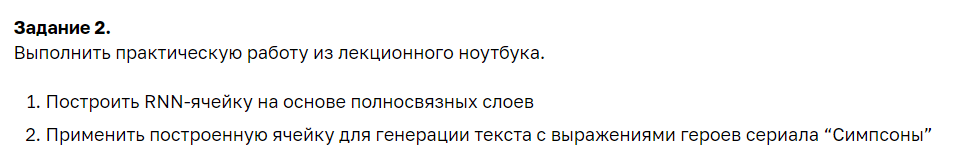

In [4]:
df = pd.read_csv('simpsons_script_lines.csv')
df.head()

<ipython-input-4-7fb9962208ac>:1: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('simpsons_script_lines.csv')


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158271 entries, 0 to 158270
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  158271 non-null  int64  
 1   episode_id          158271 non-null  int64  
 2   number              158271 non-null  int64  
 3   raw_text            158271 non-null  object 
 4   timestamp_in_ms     158271 non-null  object 
 5   speaking_line       158271 non-null  object 
 6   character_id        140750 non-null  object 
 7   location_id         157864 non-null  float64
 8   raw_character_text  140749 non-null  object 
 9   raw_location_text   157863 non-null  object 
 10  spoken_words        132112 non-null  object 
 11  normalized_text     132087 non-null  object 
 12  word_count          132112 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 15.7+ MB


In [6]:
phrases = df['normalized_text'].tolist()  # колонка с предобработанными текстами
phrases[:10]

['no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows its only natural that you think you have it',
 'wheres mr bergstrom',
 'i dont know although id sure like to talk to him he didnt touch my lesson plan what did he teach you',
 'that life is worth living',
 'the polls will be open from now until the end of recess now just in case any of you have decided to put any thought into this well have our final statements martin',
 'i dont think theres anything left to say',
 'bart',
 'victory party under the slide',
 nan,
 'mr bergstrom mr bergstrom']

In [7]:
text = [[c for c in ph] for ph in phrases if type(ph) is str]

In [8]:
CHARS = set('abcdefghijklmnopqrstuvwxyz ')  # все символы, которые мы хотим использовать для кодировки = наш словарь
INDEX_TO_CHAR = ['none'] + [w for w in CHARS]  # все неизвестные символы будут получать тег none
CHAR_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_CHAR)}  # словарь токен-индекс

In [39]:
len(INDEX_TO_CHAR)

28

In [9]:
MAX_LEN = 50  # мы хотим ограничить максимальную длину ввода
X = torch.zeros((len(text), MAX_LEN), dtype=int)  # создаём пустой вектор для текста, чтобы класть в него индексы токенов
for i in range(len(text)):  # для каждого предложения
    for j, w in enumerate(text[i]):  # для каждого токена
        if j >= MAX_LEN:
            break
        X[i, j] = CHAR_TO_INDEX.get(w, CHAR_TO_INDEX['none'])

In [10]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.embedding = torch.nn.Embedding(28, 30)
        self.rnn1 = torch.nn.RNN(30, 128, batch_first=True)
        self.rnn2 = torch.nn.RNN(128, 64, batch_first=True)  # Новый слой RNN
        self.out = torch.nn.Linear(64, 28)

    def forward(self, sentences, state=None):
        x = self.embedding(sentences)
        x, s1 = self.rnn1(x)  # Первый слой RNN
        x, s2 = self.rnn2(x)  # Второй слой RNN
        return self.out(x)


In [11]:
model = Network()

In [12]:
criterion = torch.nn.CrossEntropyLoss()  # типичный лосс многоклассовой классификации
optimizer = torch.optim.SGD(model.parameters(), lr=.01)

In [14]:
for ep in range(10):
    start = time.time()
    train_loss = 0.
    train_passed = 0

    for i in range(int(len(X) / 100)):
        # берём батч в 100 элементов
        batch = X[i * 100:(i + 1) * 100]
        X_batch = batch[:, :-1]
        Y_batch = batch[:, 1:].flatten()

        optimizer.zero_grad()
        answers = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_CHAR))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1

    print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, time.time() - start, train_loss / train_passed))

Epoch 0. Time: 45.807, Train loss: 1.738
Epoch 1. Time: 44.883, Train loss: 1.661
Epoch 2. Time: 45.621, Train loss: 1.617
Epoch 3. Time: 44.383, Train loss: 1.585
Epoch 4. Time: 45.719, Train loss: 1.559
Epoch 5. Time: 44.558, Train loss: 1.537
Epoch 6. Time: 45.524, Train loss: 1.517
Epoch 7. Time: 45.139, Train loss: 1.499
Epoch 8. Time: 45.163, Train loss: 1.483
Epoch 9. Time: 45.600, Train loss: 1.468


In [15]:
CHAR_TO_INDEX['none']

0

In [16]:
def generate_sentence(word):
    sentence = list(word)
    sentence = [CHAR_TO_INDEX.get(s, 0) for s in sentence]
    answers = model.forward(torch.tensor(sentence))
    probas, indices = answers.topk(1)
    return ''.join([INDEX_TO_CHAR[ind.item()] for ind in indices.flatten()])

In [17]:
generate_sentence('dog')

'on '

In [19]:
generate_sentence('think')

'hetg '

In [21]:
generate_sentence('you have decided')

'ou dane toahn   '

In [20]:
generate_sentence('It is')

'nonehi  '